#Theme of this notebook - Financial event analysis
* This is a memo for event analysis method
* Let's practice throughout solving sample progrem

# Problem
On August 12, 2020 Tesla announced a 5 to 1 stock split. some news said that a group of investors with inside information to the company’s operation have benefited from the news.<br>
Test whether the pre-split changes in the stock price of TSLA was due to random fluctuations of the market or due to the leak of the stock split information.

# Overview of event analysis
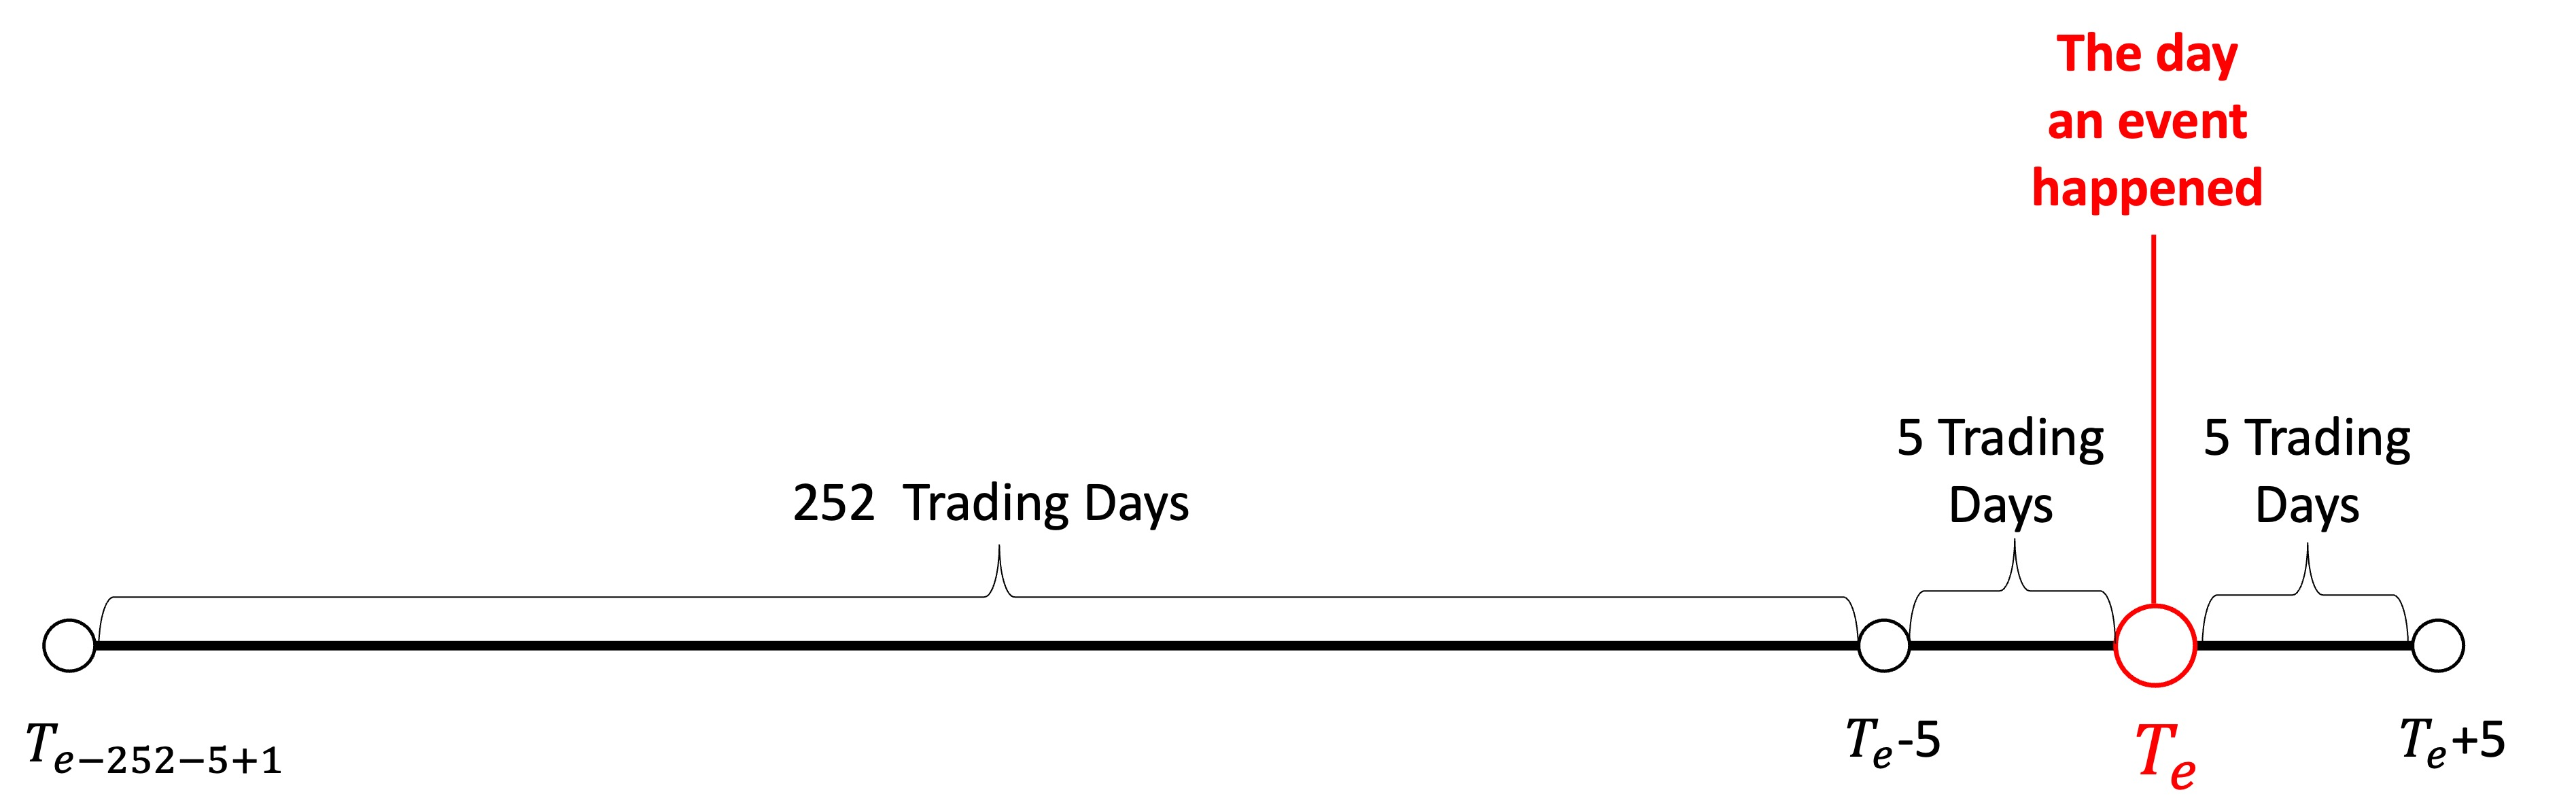

In order to investigate the effect of Tesla's event, you can do following steps.
1. Create a forecasting model by using 252 trading days of Tesla's adjasted closing prices.
2. Calculate abnormal returns (= actual returns - expected returns) and cumulative abnormal returns from five trading days before the event happened to five trading days after the event (Total 11 trading days).
3. Test t statistics of the abnormal returns.

In [58]:
# First, retrive data from Yahoo Finance
# Before that, let's install pandas-datareader
! pip install pandas-datareader

In [59]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf

In [60]:
# Let's create the forecasting model
# To create the model, retrive tesla's and S&P500's data from 2019-08-02 to 2020-08-04.(returns on 252 trading days)
tesla_for_model = yf.download('TSLA', start='2019-08-02', end='2020-08-04')
sp500_for_model = yf.download('^GSPC', start='2019-08-02', end='2020-08-04')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [61]:
# Set variables
tesla_for_model = pd.DataFrame(tesla_for_model.loc['2019-08-02':'2020-08-04', 'Adj Close'])
sp500_for_model = pd.DataFrame(sp500_for_model.loc['2019-08-02':'2020-08-04', 'Adj Close'])

# Calculate logarithmic returns
tesla_for_model['log_ret'] = np.log(tesla_for_model ['Adj Close'] / tesla_for_model ['Adj Close'].shift(1))
sp500_for_model['log_ret'] = np.log(sp500_for_model['Adj Close'] / sp500_for_model['Adj Close'].shift(1))

# Reset variables
tesla_for_model = tesla_for_model['log_ret']
sp500_for_model = sp500_for_model['log_ret']

# Set intercept
sp500_for_model = sm.add_constant(sp500_for_model)

In [62]:
model_tesla = sm.OLS(tesla_for_model.dropna(),sp500_for_model.dropna())
result_tesla = model_tesla.fit()
result_tesla.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     85.70
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           9.84e-18
Time:                        10:05:15   Log-Likelihood:                 434.70
No. Observations:                 252   AIC:                            -865.4
Df Residuals:                     250   BIC:                            -858.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      2.486      0.014       0.001       0.012
log_ret        1.1815      0.128      9.257      0.000       0.930       1.433
==============================================================================
Omnibus:                       30.139   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.256
Skew:                           0.117   Prob(JB):                     4.79e-37
Kurtosis:                       6.984   Cond. No.                         46.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# Set alpha and beta
alpha = result_tesla.params[0]
beta = result_tesla.params[1]
print(alpha,beta)

0.006780376695004562 1.1814630891969744


According to the result, the forecasting model is as follows:<br>
E($R_a$) = 0.0068 + 1.1815 * $R_m$

In [64]:
# Second, let's calculate abnormal returns
# To calculate abnormal returns, retrive tesla's and S&P500's data from 2020-08-04 to 2020-08-20 (returns on 11 trading days)
tesla_for_abnormal = yf.download('TSLA', start='2020-08-04', end='2020-08-20')
sp500_for_abnormal = yf.download('^GSPC', start='2020-08-04', end='2020-08-20')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [65]:
# Calculate each daily return
returns_for_abnormal = pd.DataFrame()
returns_for_abnormal['TSLA_ret'] = np.log(tesla_for_abnormal ['Adj Close'] / tesla_for_abnormal['Adj Close'].shift(1))
returns_for_abnormal['S&P500_ret'] = np.log(sp500_for_abnormal ['Adj Close'] / sp500_for_abnormal['Adj Close'].shift(1))
returns_for_abnormal

,TSLA_ret,S&P500_ret
Date,,
2020-08-04,NaN,NaN
2020-08-05,-0.001332,0.006409
2020-08-06,0.003066,0.006407
2020-08-07,-0.025063,0.000633
2020-08-10,-0.023781,0.002738
2020-08-11,-0.031639,-0.008001
2020-08-12,0.123311,0.013900
2020-08-13,0.041722,-0.002049
2020-08-14,0.018162,-0.000172


In [66]:
# Calculate each daily expected return
returns_for_abnormal['EXP_ret'] = alpha + beta * returns_for_abnormal['S&P500_ret']

# Calculate abnormal returns (= Actual return - expected return) and cumulative abnormal returns
returns_for_abnormal['Abnormal_ret'] = returns_for_abnormal['TSLA_ret'] - returns_for_abnormal['EXP_ret']
returns_for_abnormal['Cum_Abnormal_ret'] = pd.DataFrame.cumsum(returns_for_abnormal['Abnormal_ret'])

returns_for_abnormal

,TSLA_ret,S&P500_ret,EXP_ret,Abnormal_ret,Cum_Abnormal_ret
Date,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN
2020-08-05,-0.001332,0.006409,0.014353,-0.015685,-0.015685
2020-08-06,0.003066,0.006407,0.014350,-0.011284,-0.026969
2020-08-07,-0.025063,0.000633,0.007528,-0.032591,-0.059561
2020-08-10,-0.023781,0.002738,0.010016,-0.033797,-0.093358
2020-08-11,-0.031639,-0.008001,-0.002673,-0.028967,-0.122325
2020-08-12,0.123311,0.013900,0.023202,0.100109,-0.022216
2020-08-13,0.041722,-0.002049,0.004359,0.037363,0.015147
2020-08-14,0.018162,-0.000172,0.006577,0.011585,0.026732


# Note: T-statistics for event analysis
* In this case, t-statistics is as follows<br>
$t = \frac{AR}{S.E. \ of \ the \ regression \  model} $<br>
where AR = Abnormal Returns and S.E. = Standard Error

In [67]:
# Set standard error of the regression model
std_err = result_tesla.scale**.5
std_err

0.04328430038490788

In [68]:
# Third, let's check T statistics(=AR/S.E.)
returns_for_abnormal['t_stats'] = returns_for_abnormal['Abnormal_ret'] / std_err

# Check whether t>1.96 or not
returns_for_abnormal['t>1.96?'] = returns_for_abnormal['t_stats'] > 1.96
returns_for_abnormal

,TSLA_ret,S&P500_ret,EXP_ret,Abnormal_ret,Cum_Abnormal_ret,t_stats,t>1.96?
Date,,,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN,False
2020-08-05,-0.001332,0.006409,0.014353,-0.015685,-0.015685,-0.362370,False
2020-08-06,0.003066,0.006407,0.014350,-0.011284,-0.026969,-0.260699,False
2020-08-07,-0.025063,0.000633,0.007528,-0.032591,-0.059561,-0.752963,False
2020-08-10,-0.023781,0.002738,0.010016,-0.033797,-0.093358,-0.780820,False
2020-08-11,-0.031639,-0.008001,-0.002673,-0.028967,-0.122325,-0.669221,False
2020-08-12,0.123311,0.013900,0.023202,0.100109,-0.022216,2.312826,True
2020-08-13,0.041722,-0.002049,0.004359,0.037363,0.015147,0.863196,False
2020-08-14,0.018162,-0.000172,0.006577,0.011585,0.026732,0.267648,False


# Verdict
The pre-split changes in the stock price of TSLA were due to random fluctuations of the market.<br>
This is because t-statistics of the abnormal returns from 2020-08-05 to 2020-08-11 were not statitically significant as shown above.

# Conclusion

* We can investigate the effect of a financial event by using this method